In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as nplin
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')

In [3]:
logging.basicConfig(filename='convergence.tmp.log', level=logging.INFO)
logging.captureWarnings(True)

## Setup the True Parameters /  Simulation Parameters

## Setup the linking functions.

In [4]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.gamma(rho=true_params['rho'], scale=true_params['scale'], delta=true_params['delta'], 
                       phi=true_params['phi'], pi=true_params['vol_price'], theta=true_params['equity_price']),
     'beta':vl.beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['vol_price'], theta=true_params['equity_price']),
     'psi':vl.psi(true_params['rho'], true_params['scale'], true_params['phi'], 
                  theta=true_params['equity_price']), 
     'phi_squared': true_params['phi']**2})

NameError: name 'true_params' is not defined

## We start by examining the distributions of simulated data

In [ ]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [ ]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()


In [ ]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [ ]:
data.describe()

## I now estimate all of the parameters

In [56]:
true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'phi':-.17,
               'scale': .1,
               'delta': 1,
               'rho': 0,
              }
time_dim = 10000
sim_dim = 200

In [57]:
results = np.arange(sim_dim)

In [58]:
data = vl.simulate_data(time_dim=time_dim, **true_params)


In [59]:
vol_data = vl.simulate_autoregressive_gamma(delta=1, rho=0, scale=1,time_dim=time_dim)


In [60]:
def get_data_and_results(x):
    data = vl.simulate_data(time_dim=time_dim, **true_params)
    init_constants = vl.compute_init_constants(data.vol)
    vol_est = vl.compute_vol_gmm(data.vol, init_constants=init_constants)
    return data, vol_est

In [61]:
# with Pool(8) as pool:
data_arr, est_arr = zip(*[result  for result in tqdm.tqdm_notebook(
    map(get_data_and_results, results), total=len(results))])

In [62]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean   / np.sqrt(np.diag(cov) / data.vol.size)

In [68]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'], rho=true_params['rho'], 
                scale=true_params['scale'])) for data in tqdm.tqdm_notebook(data_arr)])

In [69]:
moment_data.mean()

0     0.065776
1    27.918623
2     0.028339
3    16.627118
4    11.702735
dtype: float64

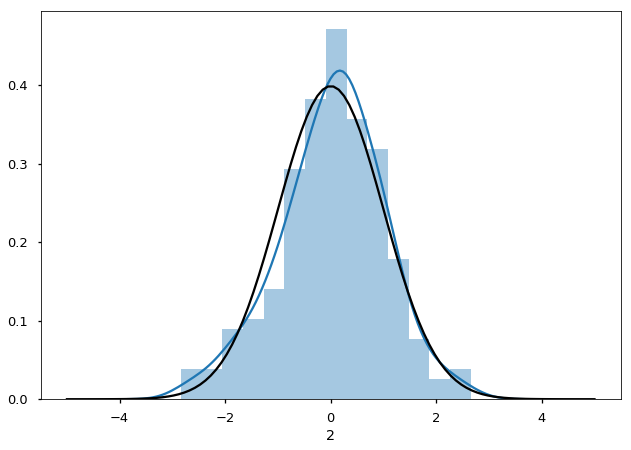

In [70]:
moment_fig, moment_ax = mpl.pyplot.subplots()
sns.distplot(moment_data.iloc[:,2], ax=moment_ax)
moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

In [37]:
data_arr[0].vol.apply(np.square).mean()

0.07815154251497022

In [38]:
vl.vol_moments_grad(data_arr[0].vol, true_params['delta'], true_params['rho'], true_params['scale'])

,delta,rho,scale
0,-0.100000,-0.199358,-1.000000
1,-0.019936,-0.078158,-0.199358
2,-0.049936,-0.157902,-0.798717
3,-0.013797,-0.076654,-0.236060
4,-0.006884,-0.052715,-0.122044


Text(0.5,0,'delta')

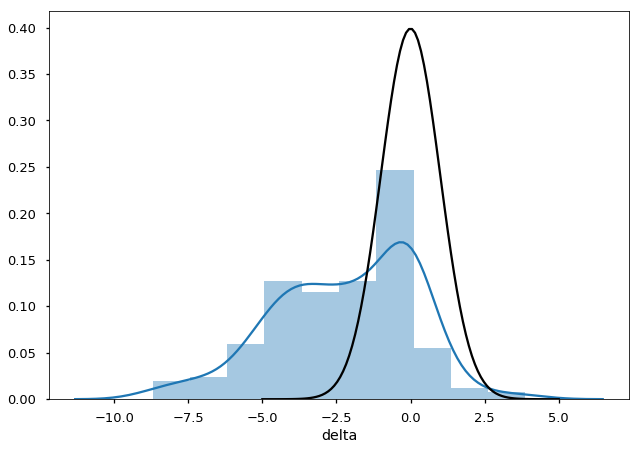

In [39]:
delta_fig, delta_ax = mpl.pyplot.subplots()
sns.distplot([(est['delta'] - true_params['delta']) / np.sqrt(cov.loc['delta','delta']) 
              for est, cov in est_arr], ax=delta_ax)
delta_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
delta_ax.set_xlabel('delta')

In [40]:
np.mean([(est['scale'] - true_params['scale']) / np.sqrt(cov.loc['scale', 'scale'])  for est, cov in est_arr])

-0.00095117174334269795

In [41]:
np.mean(np.arange(6).reshape((2,3)), axis=0)

array([ 1.5,  2.5,  3.5])

Text(0.5,0,'scale')

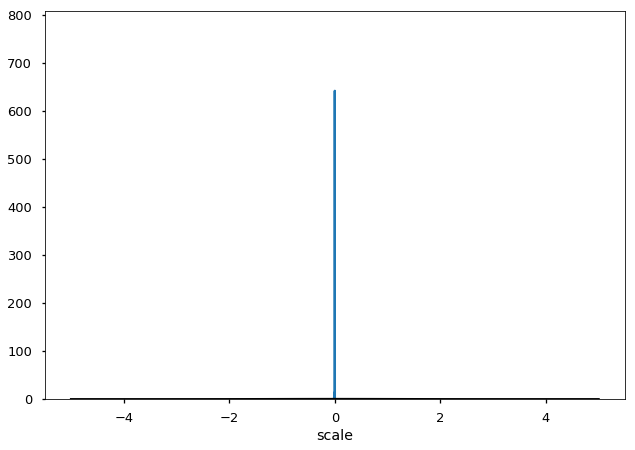

In [42]:
scale_fig, scale_ax = mpl.pyplot.subplots()
sns.distplot([(est['scale'] - true_params['scale']) / np.sqrt(cov.loc['scale', 'scale']) 
              for est, cov in est_arr], ax=scale_ax)
scale_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
scale_ax.set_xlabel('scale')

In [43]:
np.mean([(est['rho'] - true_params['rho']) / np.sqrt(cov.loc['rho', 'rho']) for est, cov in est_arr])

0.030551770708299949

Text(0.5,0,'rho')

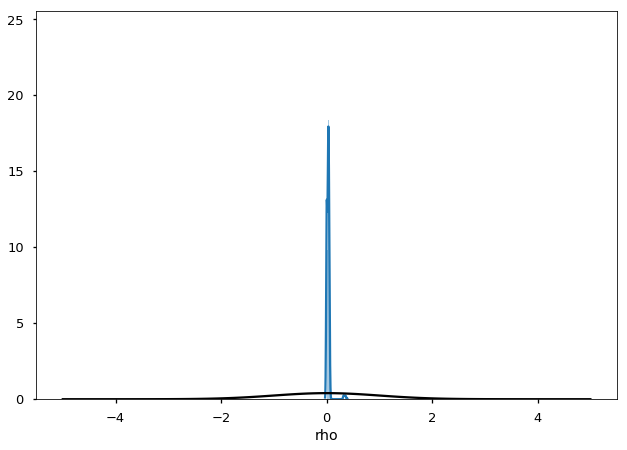

In [44]:
rho_fig, rho_ax = mpl.pyplot.subplots()
sns.distplot([(est['rho'] - true_params['rho']) / np.sqrt(cov.loc['rho', 'rho']) 
              for est, cov in est_arr], ax=rho_ax)
rho_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
rho_ax.set_xlabel('rho')

In [23]:
vol_tables = [vl.create_est_table(estimates=est, truth=total_true_params, cov=cov)
                 for est,cov in vol_est_arr]

NameError: name 'vol_est_arr' is not defined

In [24]:
pd.DataFrame([frame.truth - frame.estimate for frame in vol_tables]).mean(axis=0)

NameError: name 'vol_tables' is not defined

In [25]:
stage2_estimates, stage2_cov = vl.estimate_params(data)


In [26]:
vl.create_est_table(estimates=stage2_estimates, truth=total_true_params, cov=stage2_cov)

NameError: name 'total_true_params' is not defined

In [27]:
vl.cov_to_corr(stage2_cov)

,delta,equity_price,phi,rho,scale,vol_price
delta,1.000000,0.992016,0.992097,0.993200,0.985985,0.976936
equity_price,0.992016,1.000000,0.999905,0.999549,0.997409,0.991350
phi,0.992097,0.999905,1.000000,0.999619,0.997446,0.991337
rho,0.993200,0.999549,0.999619,1.000000,0.995882,0.988788
scale,0.985985,0.997409,0.997446,0.995882,1.000000,0.998187
vol_price,0.976936,0.991350,0.991337,0.988788,0.998187,1.000000
